This example is taken from the following website: http://www.pricederivatives.com/en/derivatives-cva-example-monte-carlo-python/. We've taken advantage of some functionalities provided by pyql to simplify the computations.

Here we’ll show an example of code for CVA calculation (credit valuation adjustment) with Python and Quantlib using a simple Monte-Carlo method for a portfolio consisting solely of a single interest rate swap. It’s easy to generalize this code to include more financial instruments.


#### CVA calculation algorithm:

1) Simulate yield curve at future dates.

2) Calculate your derivatives portfolio NPV (net present value) at each time point for each scenario.

3) Calculate CVA as sum of Expected Exposure multiplied by probability of default at this interval

$$CVA = (1-R) \int{DF(t) EE(t) dQ_t}$$

where $R$ is the Recovery (normally set to 40%), $EE(t)$ the expected exposure at time $t$, $dQ$ the survival probability density, and $DF(t)$ discount factor at time $t$.

#### Outline

1) In this simple example, we will use the Hull White model to generate future yield curves. In practice, many banks use some yield curve evolution models based on historical simulations.
In the Hull White model, the short rate $r_t$ is distributed normally with known mean and variance.

2) For each point of time we will generate whole yield curve based on short rate. Then we will price our interest rate swap on each of these curves.


3) to approximate CVA we will use BASEL III formula for regulatory capital charge approximating default probability [or survival probability ] as exp(-ST/(1-R))
so we get:

$$CVA= (1-R) \sum \frac{EE^{*}_{T_{i}}+EE^{*}_{T_{i-1}}}{2} (e^{-\frac{ST_{i-1}}{1-R}}-e^{-\frac{ST_{i}}{1-R}})^+$$
where $EE^{*}$ is discounted Expected exposure of portfolio.

### Hull-White model for future yield curve simulations 

the model is given by dynamics:

$$dr_t=(\theta_t-ar_t)dt+\sigma dW_t$$

In the Hull White model, the short rate $r_t$ is distributed normally with mean and variance given by
$$E(r_t|r_s)=r_se^{-a(t-s)}+\gamma_t-\gamma_se^{-a(t-s)}$$
$$Var(r_t|r_s)=\frac{\sigma^2}{2a}(1-e^{-2a(t-s)})$$
where $\gamma_t=f_t(0)+\frac{\sigma^2}{2a}(1-e^{-at})^2$
and $f_t(0)$ is the instantaneous forward rate at time $t$ as seen at time 0.
The calculations will not depend on $\theta_t$.
To generate the future values of $r_t$, we use the `simulate_process` function which is a convenience function provided in the simulate module of pyql.
After getting a matrix of all $r_t $for all draws and time points, we will construct a yield curve for each $r_t$ using Hull White discount factors $E(r_{t_i})$ at each future date.

$$P_{\rightarrow T}(0)= E( e^{-\int_0^Tr_sds})=E( E(e^{-\int_0^Tr_sds}|\mathcal{F}_{t_i}))=E(P_{\rightarrow t_i}(0)E(e^{-\int_{t_i}^Tr_sds}|\mathcal{F}_{t_i}))$$ for each future time point $t_i$, $T$ being the maturity.

also we'll output some generated yield curves.

In [1]:
from quantlib.settings import Settings
from quantlib.time.api import (Date, Actual360, TARGET, NoFrequency, Period,
                               Years, Schedule, ModifiedFollowing, Forward)
from quantlib.termstructures.yields.api import DiscountCurve

todaysDate = Date(26, 12, 2013);
Settings().evaluation_date = todaysDate;
crvTodaydates = [Date(26, 12, 2013),
                 Date(30, 6, 2014),
                 Date(30, 7, 2014),
                 Date(29, 8, 2014),
                 Date(30, 9, 2014),
                 Date(30, 10, 2014),
                 Date(28, 11, 2014),
                 Date(30, 12, 2014),
                 Date(30, 1, 2015),
                 Date(27, 2, 2015),
                 Date(30, 3, 2015),
                 Date(30, 4, 2015),
                 Date(29, 5, 2015),
                 Date(30, 6, 2015),
                 Date(30, 12, 2015),
                 Date(30, 12, 2016),
                 Date(29, 12, 2017),
                 Date(31, 12, 2018),
                 Date(30, 12, 2019),
                 Date(30, 12, 2020),
                 Date(30, 12, 2021),
                 Date(30, 12, 2022),
                 Date(29, 12, 2023),
                 Date(30, 12, 2024),
                 Date(30, 12, 2025),
                 Date(29, 12, 2028),
                 Date(30, 12, 2033),
                 Date(30, 12, 2038),
                 Date(30, 12, 2043),
                 Date(30, 12, 2048),
                 Date(30, 12, 2053),
                 Date(30, 12, 2058),
                 Date(31, 12, 2063)]
crvTodaydf=[1.0,
            0.998022,
            0.99771,
            0.99739,
            0.997017,
            0.996671,
            0.996337,
            0.995921,
            0.995522,
            0.995157,
            0.994706,
            0.994248,
            0.993805,
            0.993285,
            0.989614,
            0.978541,
            0.961973,
            0.940868,
            0.916831,
            0.890805,
            0.863413,
            0.834987,
            0.807111,
            0.778332,
            0.750525,
            0.674707,
            0.575192,
            0.501258,
            0.44131,
            0.384733,
            0.340425,
            0.294694,
            0.260792
            ]

crvToday = DiscountCurve(crvTodaydates, crvTodaydf, Actual360(), TARGET())

In [2]:
import numpy as np
months = range(3, 12 * 5 + 1, 3)
sPeriods = ["{}M".format(month) for month in months]
print(sPeriods)

Dates = [todaysDate] + [todaysDate + Period(s) for s in sPeriods]
T = np.array([Actual360().year_fraction(todaysDate, d) for d in Dates])

['3M', '6M', '9M', '12M', '15M', '18M', '21M', '24M', '27M', '30M', '33M', '36M', '39M', '42M', '45M', '48M', '51M', '54M', '57M', '60M']


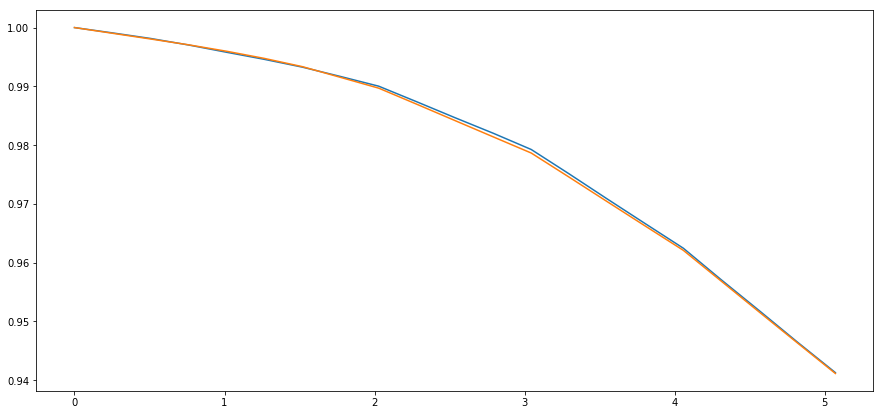

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)
from quantlib.processes.api import HullWhiteProcess
from quantlib.sim.simulate import simulate_process
from quantlib.time_grid import TimeGrid

Nsim = 1000

#parameters calibrated with Quantlib to coterminal swaptions on 26/dec/2013
a = 0.376739
sigma = 0.0209835

hw = HullWhiteProcess(crvToday, a, sigma)
grid = TimeGrid.from_vector(T)
rmat = simulate_process(hw, Nsim, grid, 1, antithetic=False)
dT = np.diff(T)

#check that bond prices match the original discount factors
bonds = np.empty_like(rmat)
bonds[1:] = np.exp(-(rmat[1:] * dT[:,None]).cumsum(axis=0))
bonds[0] = 1
bonds_mean = np.mean(bonds, axis=1)
plt.plot(T, bonds_mean)
plt.plot(T, [crvToday.discount(t) for t in T])
plt.show()

In [4]:
from quantlib.models.shortrate.onefactormodels.hullwhite import HullWhite

start_date = Date(26, 12, 2013);
hw_model = HullWhite(crvToday, a, sigma)
crvMat = np.empty((len(T), Nsim), dtype='object')
crvMat[0] = crvToday
for i in range(1, len(T)):
    crvDates = [Dates[i] + Period(k, Years) for k in range(21)]
    crv_row = []
    for n in range(Nsim):
        rt = rmat[i, n]
        crvDiscounts = [hw_model.discount_bound(T[i], T[i] + k, rt) for k in np.arange(21.)]
        crvMat[i, n] = DiscountCurve(crvDates, crvDiscounts, Actual360(), TARGET())

bondT = np.zeros_like(rmat)
for n in range(Nsim):
    for i in range(len(T)):
        bondT[i,n] = bonds[i,n] * crvMat[i,n].discount(19 - T[i])

bondTmean = np.mean(bondT, axis=1)
np.set_printoptions(precision=4, suppress=True)
print('bondTmean-Terminal bond\n', bondTmean - crvToday.discount(19.))

bondTmean-Terminal bond
 [ 0.      0.0056  0.0053  0.0048  0.0046  0.0056  0.0058  0.0065  0.0061
  0.0057  0.0053  0.0056  0.0047  0.0048  0.004   0.0041  0.004   0.0036
  0.0042  0.0034  0.004 ]


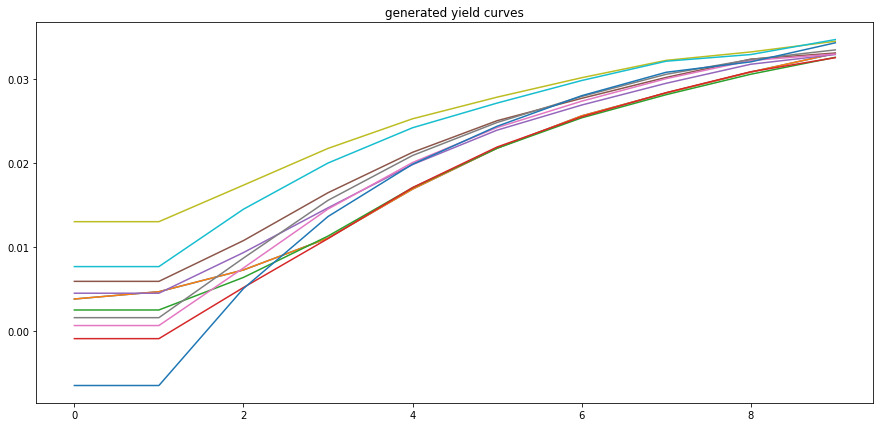

In [5]:
from quantlib.compounding import Continuous
plt.plot(range(10),
         [crvMat[0,0].forward_rate(t, t, compounding=Continuous, frequency=NoFrequency).rate
          for t in np.arange(10.)])
for i in range(min(Nsim, 10)):
    plt.plot(range(10), [crvMat[i,1].forward_rate(t, t,
                                                  compounding=Continuous, frequency=NoFrequency).rate
                         for t in np.arange(10.)])
plt.title('generated yield curves')
plt.show()

In [6]:
from quantlib.indexes.api import Euribor6M
from quantlib.instruments.api import VanillaSwap, Receiver
from quantlib.pricingengines.swap import DiscountingSwapEngine
from quantlib.termstructures.yields.api import YieldTermStructure

#indexes definition
forecast_term_structure = YieldTermStructure()
index = Euribor6M(forecast_term_structure)

rmean = [hw.expectation(0., hw.x0, t) for t in T]

# we add a fixing every 6 months
for i in range(0, len(Dates), 2):
    index.add_fixing(index.fixing_date(Dates[i]), rmean[i])

In [7]:
#swap 1 definition
maturity = Date(26, 12, 2018)
fixed_schedule = Schedule.from_rule(start_date, maturity, Period("6M"), TARGET(),
                                    ModifiedFollowing, ModifiedFollowing, Forward,
                                    False)
floating_schedule = Schedule.from_rule(start_date, maturity, Period("6M"),
                                       TARGET(), ModifiedFollowing,
                                       ModifiedFollowing, Forward, False)
swap1 = VanillaSwap(Receiver, 10_000_000, fixed_schedule, 0.02, Actual360(),
                    floating_schedule, index, 0, Actual360())  #0.01215


In [8]:
npvMat = np.empty((len(T), Nsim))

discount_term_structure = YieldTermStructure()
swapEngine = DiscountingSwapEngine(discount_term_structure)
npvMat = np.empty((len(T), Nsim))
swap1.set_pricing_engine(swapEngine)

for i, d in enumerate(Dates):
    Settings().evaluation_date = d
    for n in range(Nsim):
        crv = crvMat[i, n]
        discount_term_structure.link_to(crv)
        forecast_term_structure.link_to(crv)
        npvMat[i, n] = swap1.npv

In [9]:
npv = npvMat[0,0]
#replace negative values with 0
npvMat[npvMat<0] = 0
EE = np.mean(npvMat, axis=1)
print('\nEE:\n', EE)
#print '\nrmat:\n',rmat
print('\nrmean:\n', rmean)
#print '\nrstd:\n',rstd
#print '\n95% are in \n',zip(rmean-2*rstd,rmean+2*rstd)


EE:
 [ 401670.1158  418836.1352  340293.5483  350128.0023  355742.385
  301135.2662  235679.9031  249760.1162  243312.1597  199152.445
  174698.3439  144657.1733  130173.2957  111075.2397   59332.7639
   64612.5595   43032.7119   35243.9918       0.           0.           0.    ]

rmean:
 [0.0038321783708768938, 0.0038447104458097666, 0.003878829192934586, 0.004304415296142585, 0.004854534792846587, 0.005486708976510404, 0.00618266474586651, 0.007652760916036794, 0.007726527486934385, 0.011583314187371059, 0.011655179426606066, 0.011724510502370677, 0.011790125103332274, 0.01767265729120667, 0.017732265414519513, 0.01778829449949869, 0.017840190647180572, 0.0227598814403213, 0.02280548353169784, 0.022847781363155784, 0.022886514765800076]


In [10]:
# We use 5% for the credit spread and 40% for the recovery
from math import exp
S = 0.05
R = 0.4
r = 0
for i in range(len(T)-1):
    r += 0.5 * crvToday.discount(T[i+1]) * (EE[i] + EE[i+1]) * (exp(-S*T[i]/(1.0-R)) -exp(-S*T[i+1]/(1.0-R)))
CVA = (1. - R) * r
print("\nnpv=", npv)
print("\nCVA=", CVA)


npv= 401670.115793

CVA= 40722.1574303
